In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import io
import fitz
from PIL import Image
import seaborn as sns
import numpy as np
import pandas as pd
import os
import sys
import json
import pickle
import mplcursors
sns.reset_orig()
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Set the output directories here
outdir_10 = 'outdir_10_percent_threshold'
outdir_aic = 'outdir_aic'

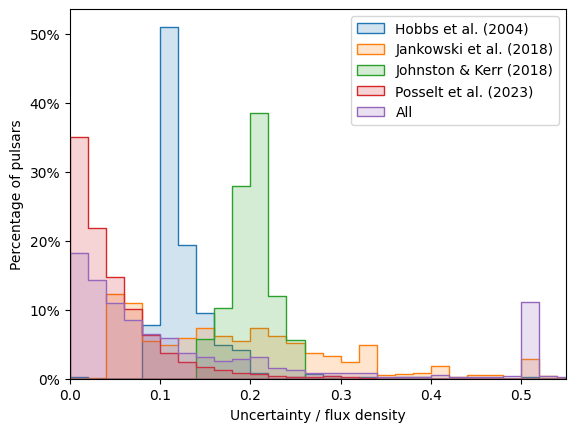

In [2]:
with open(f'../catalogue/catalogue.pkl', 'rb') as f:
    catalogue = pickle.load(f)
    
fig, ax = plt.subplots()

def uncertainty_distribution(ref_name: str, caption: str = None, ax=ax, binwidth=0.02, binrange=(0, 0.55)):
    selected_Ys = []
    selected_YERRs = []
    for jname in catalogue.cat_dict.keys():
        if ref_name == 'All':
            selected_Ys.extend(catalogue.cat_dict[jname]['Y'])
            selected_YERRs.extend(catalogue.cat_dict[jname]['YERR'])
        else:
            if ref_name in catalogue.cat_dict[jname]['REF']:
                for i, ref in enumerate(catalogue.cat_dict[jname]['REF']):
                    if ref == ref_name:
                        selected_Ys.append(catalogue.cat_dict[jname]['Y'][i])
                        selected_YERRs.append(catalogue.cat_dict[jname]['YERR'][i])
    
    selected_Ys = np.array(selected_Ys)
    selected_YERRs = np.array(selected_YERRs)
    YERR_Y = selected_YERRs / selected_Ys
    
    if caption is None and ref_name in catalogue.citation_dict:
        caption = catalogue.citation_dict[ref_name]
    else:
        caption = ref_name
        
    sns.histplot(YERR_Y, binwidth=binwidth, binrange=binrange,
                 kde=False, label=caption, ax=ax, 
                 stat='probability', element='step', alpha=0.2)
    
uncertainty_distribution('Hobbs_2004a', ax=ax)
uncertainty_distribution('Jankowski_2018', ax=ax)
uncertainty_distribution('Johnston_2018', ax=ax)
uncertainty_distribution('Posselt_2023', ax=ax)
uncertainty_distribution('All', ax=ax)
ax.set_xlim(0, 0.55)
ax.set_xlabel('Uncertainty / flux density')
ax.set_ylabel('Percentage of pulsars')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.legend()
plt.savefig('Uncertainty distribution.pdf', bbox_inches='tight')
plt.show()

Number of pulsars: 876
Number of pulsars with simple power law as the best fitting model: 38
Number of pulsars with simple power law as the best fitting model (AIC): 208


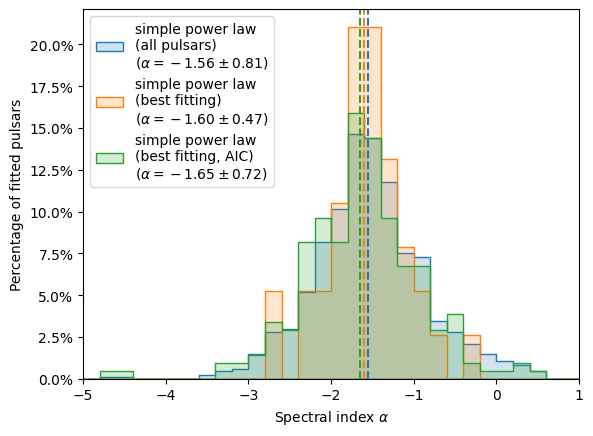

Number of pulsars with simple power law as the best fitting model: 38
Number of pulsars with low-frequency turn-over power law as the best fitting model: 79
Number of pulsars with high-frequency cut-off power law as the best fitting model: 37


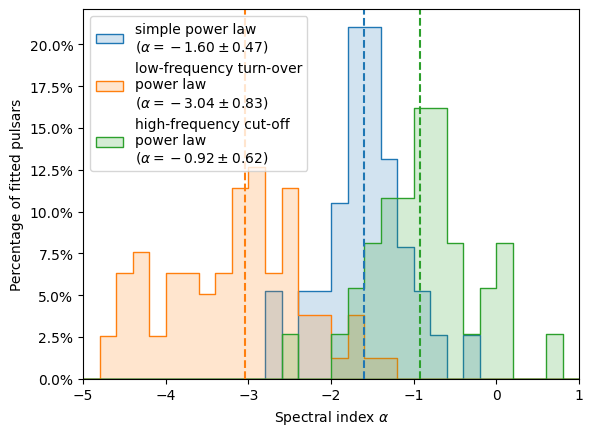

In [3]:
no_best_fit = ['J0511-6508', 'J0517+2212', 'J0536-7543', 'J0656-2228', 'J0711+0931', 'J0751+1807', 'J0834-4159', 'J0842-4851', 'J0901-4624', 'J1020-6026', 'J1028-5819', 'J1043-6116', 'J1052-5954', 'J1114-6100', 'J1126-6054', 'J1126-6942', 'J1302-6350', 'J1305-6203', 'J1357-6429', 'J1410-7404', 'J1420-6048', 'J1513-5739', 'J1534-5334', 'J1535-4114', 'J1626-4807', 'J1632-4757', 'J1636-4440', 'J1637-4642', 'J1638-4608', 'J1650-4502', 'J1652+2651', 'J1717-4054', 'J1727-2739', 'J1734-3333', 'J1735-3258', 'J1740+1000', 'J1747-2958', 'J1751-3323', 'J1758+3030', 'J1803-2137', 'J1804-0735', 'J1804-2717', 'J1806-2125', 'J1809-1917', 'J1812+0226', 'J1815-1738', 'J1816-1729', 'J1819+1305', 'J1820-1529', 'J1822-1400', 'J1824-2452A', 'J1825-1446', 'J1832-1021', 'J1837-0045', 'J1847-0438', 'J1852+0031', 'J1903+0327', 'J1910+0714', 'J1910+1231', 'J1914+1122', 'J1918+1444', 'J1921+1419', 'J2002+1637', 'J2008+2513', 'J2013+3845', 'J2038-3816', 'J2234+0611', 'J2307+2225']
def load_results(outdir: str, var: str):
    with open(f'../output/results_{var}_from_{outdir}.json', 'r', encoding='utf-8-sig') as f:
        results = pd.DataFrame(json.load(f)).T
        results['best_fitting'] = results.iloc[:, :].idxmax(axis=1) if var == 'log_evidence' else results.iloc[:, :].idxmin(axis=1)
        results.loc[no_best_fit, 'best_fitting'] = '(Unclassified)'
    return results
results_10 = load_results(outdir_10, 'log_evidence')
results_aic = load_results(outdir_aic, 'aic')

with open(f'../output/results_param_estimates_from_{outdir_10}.json', 'r', encoding='utf-8-sig') as f:
    param_est_10 = json.load(f)
    
spl_alpha_all, spl_alpha_best, spl_alpha_best_aic = [], [], []
for jname in results_10.index:
    if jname in param_est_10 and 'simple_power_law' in param_est_10[jname]:
        alpha = param_est_10[jname]['simple_power_law']['median'][0]
        spl_alpha_all.append(alpha)
        if results_10.loc[jname, 'best_fitting'] == 'simple_power_law':
            spl_alpha_best.append(alpha)
        if jname in results_aic.index and results_aic.loc[jname, 'best_fitting'] == 'simple_power_law':
            spl_alpha_best_aic.append(alpha)
            
lftopl_alpha_best, hfcopl_alpha_best = [], []
for jname in results_10.index:
    if jname in param_est_10 and 'low_frequency_turn_over_power_law' in param_est_10[jname] and results_10.loc[jname, 'best_fitting'] == 'low_frequency_turn_over_power_law':
        alpha = param_est_10[jname]['low_frequency_turn_over_power_law']['median'][1]
        lftopl_alpha_best.append(alpha)
    if jname in param_est_10 and 'high_frequency_cut_off_power_law' in param_est_10[jname] and results_10.loc[jname, 'best_fitting'] == 'high_frequency_cut_off_power_law':
        alpha = param_est_10[jname]['high_frequency_cut_off_power_law']['median'][1]
        hfcopl_alpha_best.append(alpha)
        
print(f'Number of pulsars: {len(spl_alpha_all)}')
print(f'Number of pulsars with simple power law as the best fitting model: {len(spl_alpha_best)}')
print(f'Number of pulsars with simple power law as the best fitting model (AIC): {len(spl_alpha_best_aic)}')
        
fig, ax = plt.subplots()

sns.histplot(spl_alpha_all, binwidth=0.2, binrange=(-5., 1.), kde=False, label=f'simple power law\n(all pulsars)\n($α = {np.median(spl_alpha_all):.2f} \pm {np.std(spl_alpha_all):.2f}$)', ax=ax, stat='probability', element='step', alpha=0.2)
sns.histplot(spl_alpha_best, binwidth=0.2, binrange=(-5., 1.), kde=False, label=f'simple power law\n(best fitting)\n($α = {np.median(spl_alpha_best):.2f} \pm {np.std(spl_alpha_best):.2f}$)', ax=ax, stat='probability', element='step', alpha=0.2)
sns.histplot(spl_alpha_best_aic, binwidth=0.2, binrange=(-5., 1.), kde=False, label=f'simple power law\n(best fitting, AIC)\n($α = {np.median(spl_alpha_best_aic):.2f} \pm {np.std(spl_alpha_best_aic):.2f}$)', ax=ax, stat='probability', element='step', alpha=0.2)
ylim = ax.get_ylim()
ax.vlines(np.median(spl_alpha_all), *ylim, color='C0', linestyle='--')
ax.vlines(np.median(spl_alpha_best), *ylim, color='C1', linestyle='--')
ax.vlines(np.median(spl_alpha_best_aic), *ylim, color='C2', linestyle='--')
ax.set_ylim(ylim)
ax.set_xlabel('Spectral index $α$')
ax.set_ylabel('Percentage of fitted pulsars')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlim(-5., 1.)
ax.legend(loc='upper left')
plt.savefig('Spectral index distribution (simple power law).pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()

print(f'Number of pulsars with simple power law as the best fitting model: {len(spl_alpha_best)}')
print(f'Number of pulsars with low-frequency turn-over power law as the best fitting model: {len(lftopl_alpha_best)}')
print(f'Number of pulsars with high-frequency cut-off power law as the best fitting model: {len(hfcopl_alpha_best)}')

sns.histplot(spl_alpha_best, binwidth=0.2, binrange=(-5., 1.), kde=False, label=f'simple power law\n($α = {np.median(spl_alpha_best):.2f} \pm {np.std(spl_alpha_best):.2f}$)', ax=ax, stat='probability', element='step', alpha=0.2)
sns.histplot(lftopl_alpha_best, binwidth=0.2, binrange=(-5., 1.), kde=False, label=f'low-frequency turn-over\npower law\n($α = {np.median(lftopl_alpha_best):.2f} \pm {np.std(lftopl_alpha_best):.2f}$)', ax=ax, stat='probability', element='step', alpha=0.2)
sns.histplot(hfcopl_alpha_best, binwidth=0.2, binrange=(-5., 1.), kde=False, label=f'high-frequency cut-off\npower law\n($α = {np.median(hfcopl_alpha_best):.2f} \pm {np.std(hfcopl_alpha_best):.2f}$)', ax=ax, stat='probability', element='step', alpha=0.2)

ylim = ax.get_ylim()
ax.vlines(np.median(spl_alpha_best), *ylim, color='C0', linestyle='--')
ax.vlines(np.median(lftopl_alpha_best), *ylim, color='C1', linestyle='--')
ax.vlines(np.median(hfcopl_alpha_best), *ylim, color='C2', linestyle='--')
ax.set_ylim(ylim)
ax.set_xlabel('Spectral index $α$')
ax.set_ylabel('Percentage of fitted pulsars')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlim(-5., 1.)
ax.legend(loc='upper left')
plt.savefig('Spectral index distribution (comparison).pdf', bbox_inches='tight')
plt.show()

Number of pulsars with low-frequency turn-over power law as the best fitting model: 79


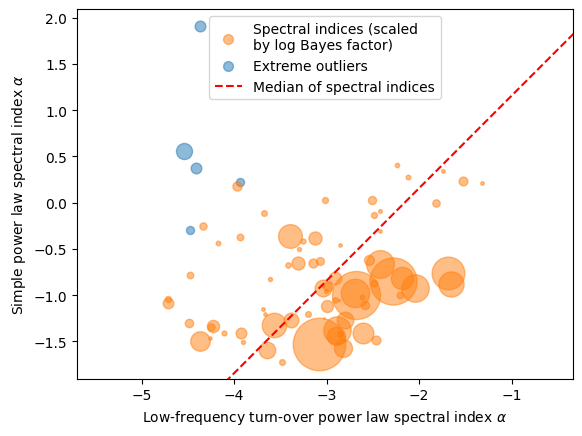

Outlier J1019-5749: α_x = -4.54, α_y = 0.55, ln BF = 67.07


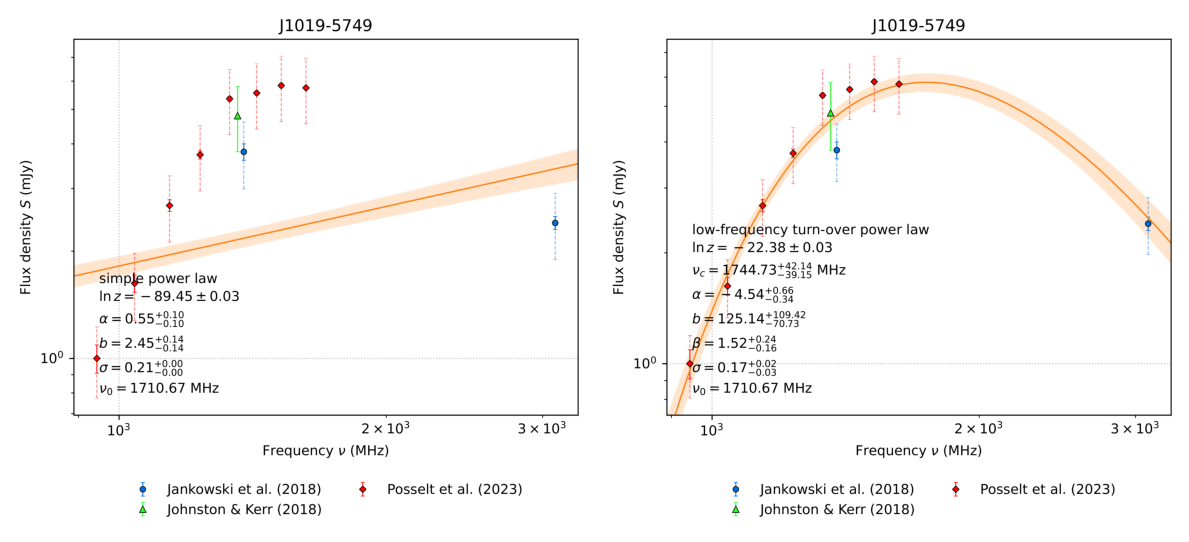

Outlier J1406-6121: α_x = -3.94, α_y = 0.22, ln BF = 16.89


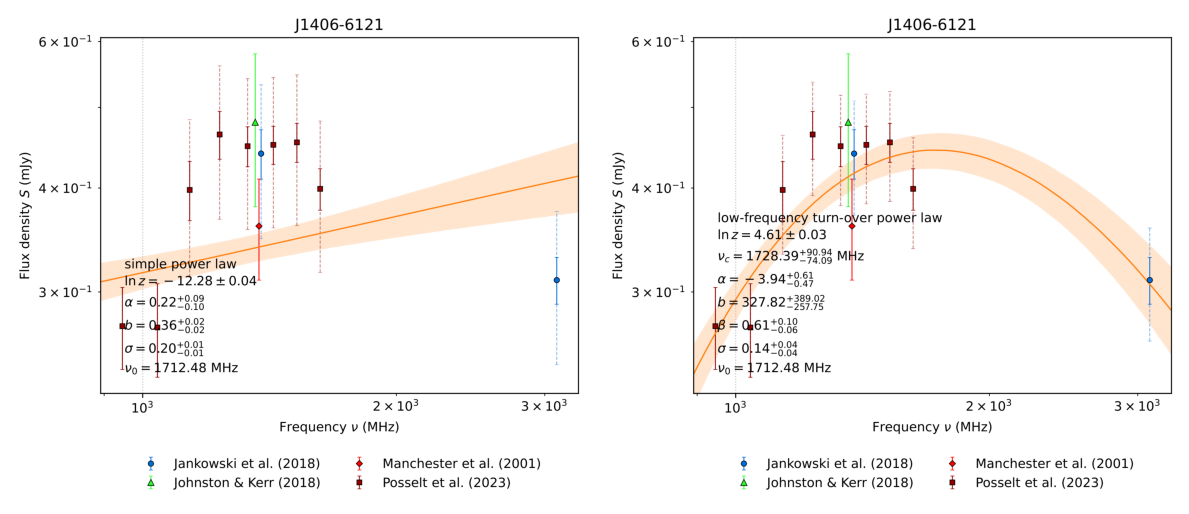

Outlier J1410-6132: α_x = -4.36, α_y = 1.91, ln BF = 30.08


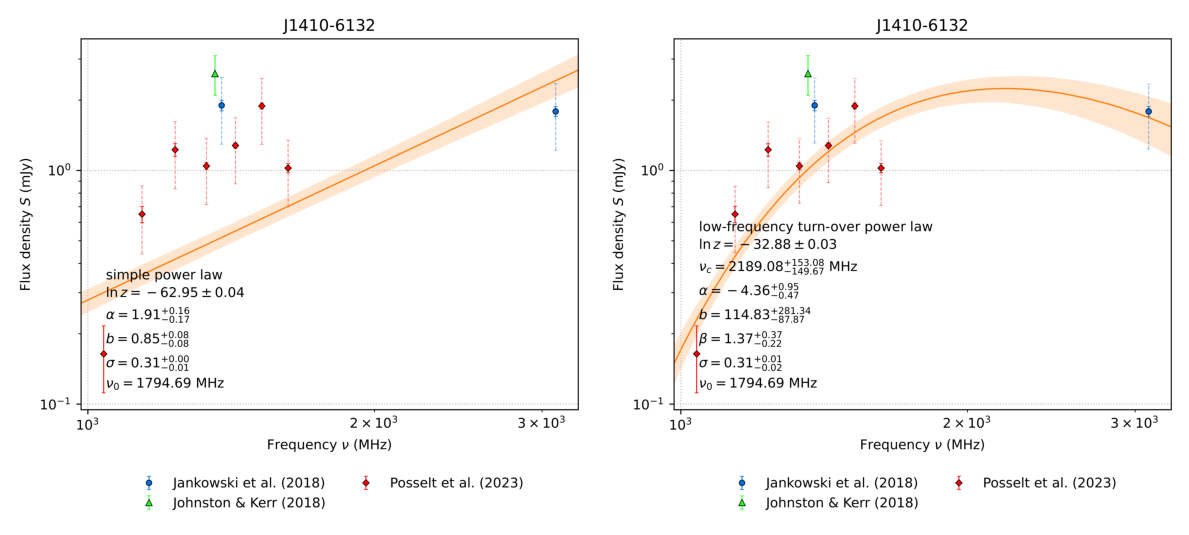

Outlier J1514-5925: α_x = -4.47, α_y = -0.30, ln BF = 17.05


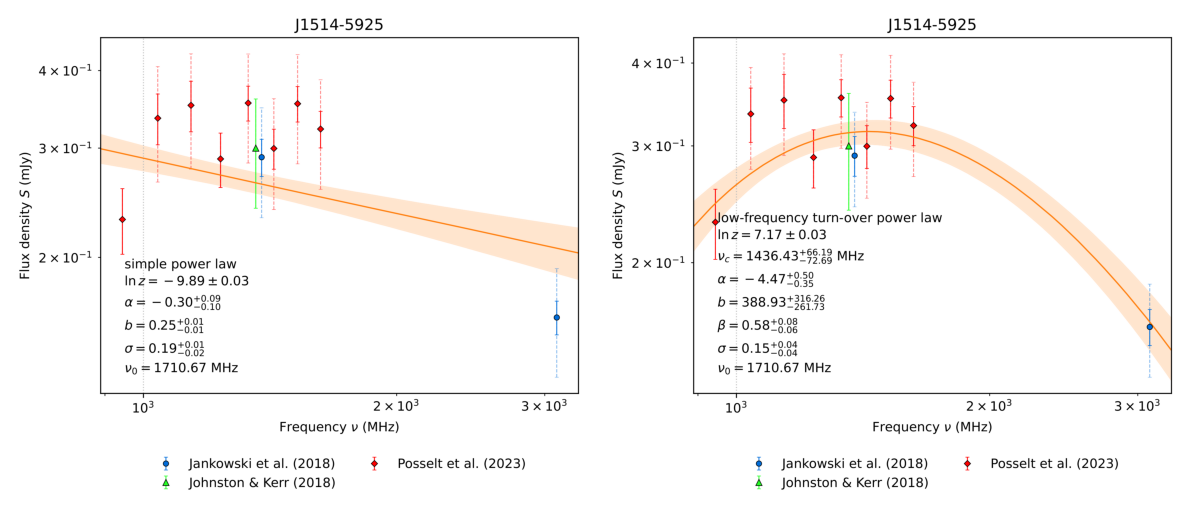

Outlier J1843-0355: α_x = -4.41, α_y = 0.38, ln BF = 29.71


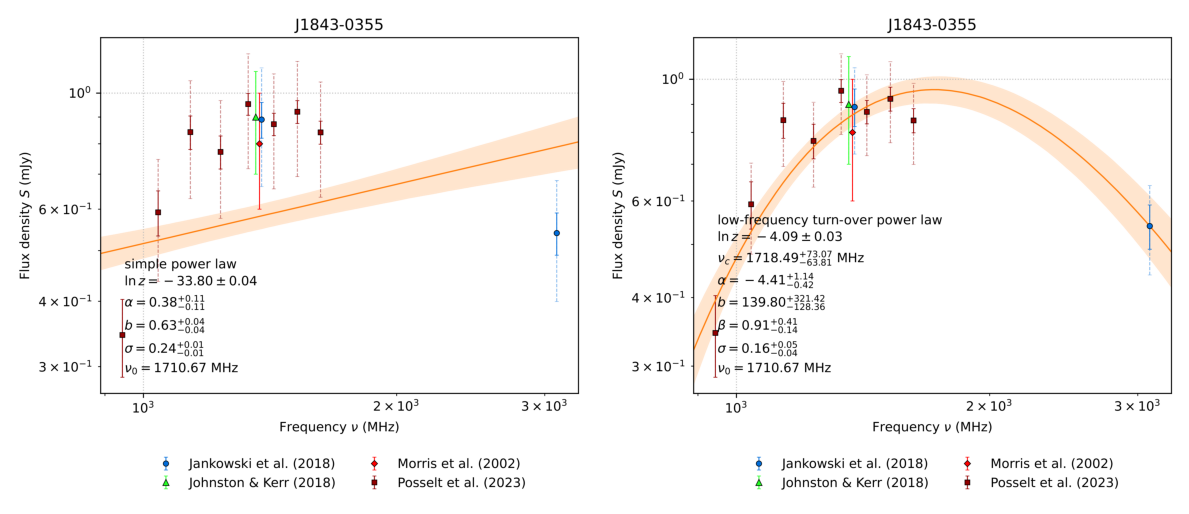

Number of pulsars with high-frequency cut-off power law as the best fitting model: 37


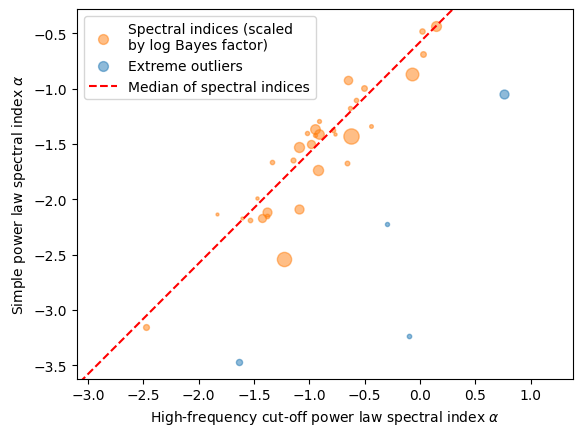

Outlier J1614-3937: α_x = -0.10, α_y = -3.23, ln BF = 5.02


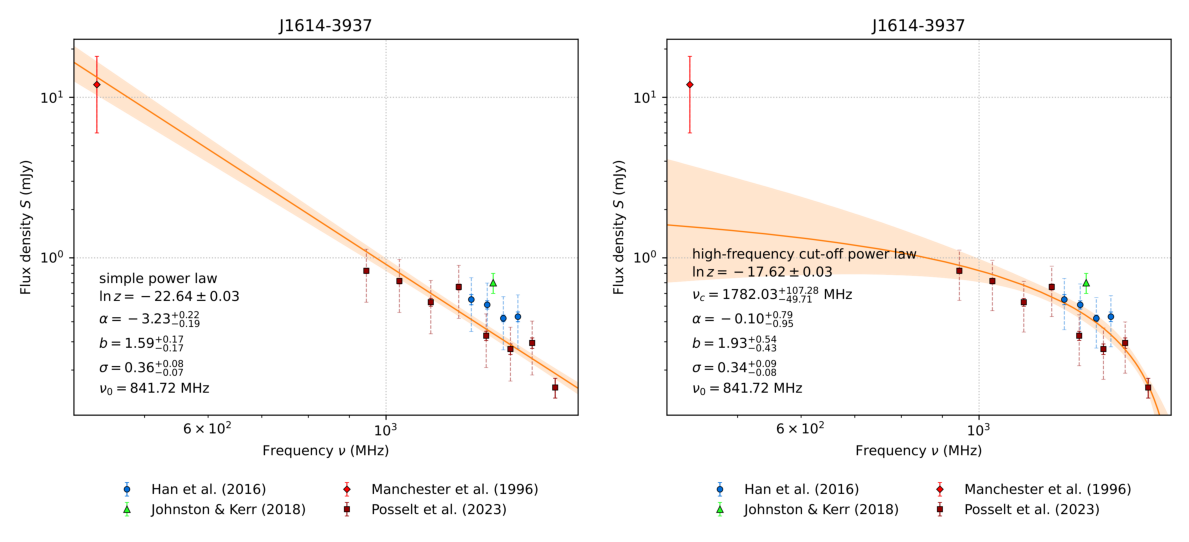

Outlier J1648-3256: α_x = -1.63, α_y = -3.47, ln BF = 9.85


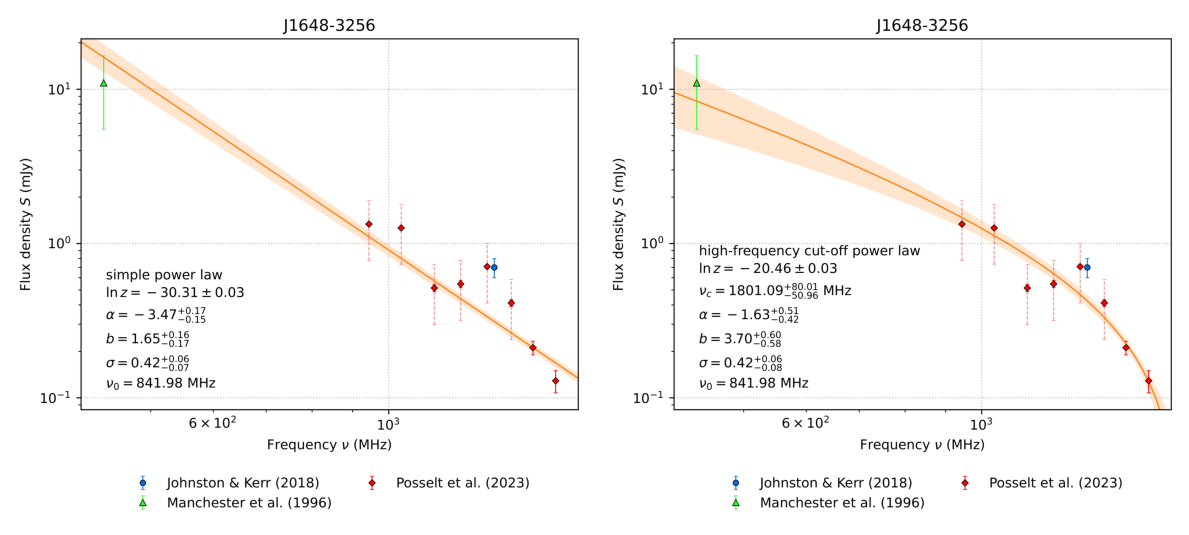

Outlier J1816-2650: α_x = -0.30, α_y = -2.23, ln BF = 4.39


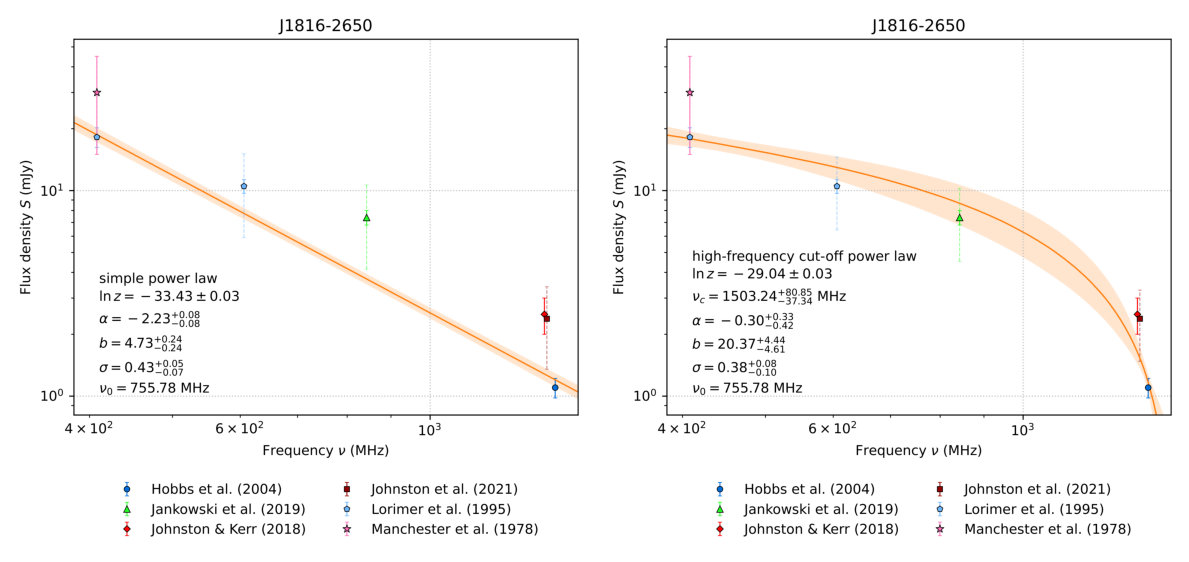

Outlier J1844-0244: α_x = 0.76, α_y = -1.05, ln BF = 20.70


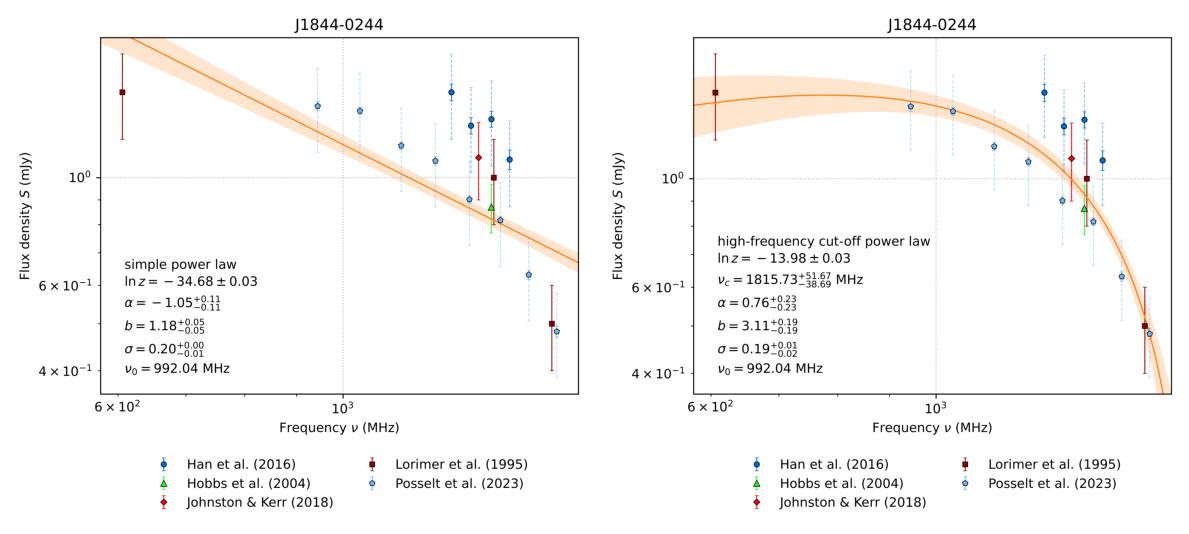

In [4]:
def get_plots(jname: str, models: list):
    fig, ax = plt.subplots(1, len(models), figsize=(len(models) * 6, 6))
    for i, model in enumerate(models):
        file_path = f'../output/{outdir_10}/{jname}/{model}_result.pdf'
        if not os.path.exists(file_path):
            continue
        pdf = fitz.open(file_path)
        page = pdf[0]
        pix = page.get_pixmap(dpi=300)
        img = Image.open(io.BytesIO(pix.tobytes()))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.tight_layout()
    plt.show()

def plot_aa_scatter(x, y, bf: list, jnames: list, model_name, xlabel, ylabel, xlim = None, ylim = None, title = '', legend_loc='best', ext_out: float=5.):
    fig, ax = plt.subplots()
    scatters, plot_jnames, plot_info = [], [], []
    for i in range(len(x)):
        if abs(y[i] - x[i] + np.median(x) - np.median(y)) > ext_out:
            plot_jnames.append(jnames[i])
            plot_info.append(f'Outlier {jnames[i]}: α_x = {x[i]:.2f}, α_y = {y[i]:.2f}, ln BF = {bf[i]:.2f}')
            scatter = plt.scatter(x[i], y[i], s=bf[i] * 2, color='tab:blue', alpha=0.5)
        else:
            scatter = plt.scatter(x[i], y[i], s=bf[i] * 2, color='tab:orange', alpha=0.5)
        scatters.append(scatter)
    if jnames is not None:
        cursor = mplcursors.cursor(scatters, hover=True)
        def get_label(sel):
            ix = np.where(np.array(scatters) == sel.artist)[0][0]
            sel.annotation.set_text(f'{jnames[ix]}\nln BF = {bf[ix]:.2f}\nx = {x[ix]:.2f}\ny = {y[ix]:.2f}')
        cursor.connect('add', get_label)
            
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()
        
    # draw a hidden point to show the scatter plot in the legend
    plt.scatter([], [], s=50, alpha=0.5, color='tab:orange', label='Spectral indices (scaled\nby log Bayes factor)')
    plt.scatter([], [], s=50, alpha=0.5, color='tab:blue', label='Extreme outliers')
    
    x_median = np.median(x)
    y_median = np.median(y)
    intercept = y_median - x_median
    plt.plot([-20, 20], [-20 + intercept, 20 + intercept], 'r--', label='Median of spectral indices')
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xlim)
    plt.ylim(ylim)
    ax.set_aspect('equal', adjustable='datalim')
    plt.legend(loc=legend_loc)
    plt.savefig(f'{title}.pdf', bbox_inches='tight')
    plt.show()
    
    for info, jname in zip(plot_info, plot_jnames):
        print(info)
        get_plots(jname, ['simple_power_law', model_name])
    
def aa_scatter(model_name: str, model_name_cap: str, interactive=False, ext_out: float=5.):
    x, y, bf, jnames = [], [], [], []
    for jname in results_10.index:
        if 'simple_power_law' in results_10.columns and model_name in results_10.columns and jname in param_est_10 and 'simple_power_law' in param_est_10[jname] and model_name in param_est_10[jname] and results_10.loc[jname, 'best_fitting'] == model_name:
            x.append(param_est_10[jname][model_name]['median'][1])
            y.append(param_est_10[jname]['simple_power_law']['median'][0])
            bf.append(results_10.loc[jname, model_name] - results_10.loc[jname, 'simple_power_law'])
            jnames.append(jname)
    
    print(f'Number of pulsars with {model_name_cap} as the best fitting model: {len(x)}')
    
    plot_aa_scatter(x, y, model_name=model_name,
                    xlabel=f'{model_name_cap.capitalize()} spectral index $α$',
                    ylabel='Simple power law spectral index $α$',
                    title=f'Spectral index comparison (simple power law vs {model_name_cap})',
                    bf=bf, jnames=jnames,
                    legend_loc='best', ext_out=ext_out)
    
INTERACTIVE = False
if INTERACTIVE:
    %matplotlib notebook
aa_scatter('low_frequency_turn_over_power_law', 'low-frequency turn-over power law', interactive=INTERACTIVE, ext_out=2.)
aa_scatter('high_frequency_cut_off_power_law', 'high-frequency cut-off power law', interactive=INTERACTIVE, ext_out=1.)